<h1 align="center">Retrieval Relevance Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine the relevance or irrelevance of documents retrieved by
retrieval-augmented generation (RAG) applications. This relevance is then used to measure the quality of each retrieval using ranking metrics such as precision@k. In order to determine whether each retrieved document is relevant or irrelevant to the corresponding query, our approach is straightforward: ask an LLM.

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to relevance classification against information retrieval datasets with ground-truth relevance labels,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

## Create GoogleDrive folder 'EVALUATING_EVALS' to store files

In [20]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [24]:
import os

folder_path = "/content/drive/MyDrive/evaluating_evals"

# Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

os.chdir('/content/drive/MyDrive/evaluating_evals')
os.getcwd()

'/content/drive/MyDrive/evaluating_evals'

In [27]:
# import shutil

# # Define source and destination paths
# src = "/content/benchmark_samples.csv"
# dst = "/content/drive/MyDrive/evaluating_evals/benchmark_samples.csv"

# # Make sure destination folder exists
# os.makedirs(os.path.dirname(dst), exist_ok=True)

# # Move the file
# shutil.move(src, dst)

'/content/drive/MyDrive/evaluating_evals/benchmark_samples.csv'

In [ ]:
# Create .env file
env_path = os.path.join(folder_path, ".env")
with open(env_path, "w") as f:
    f.write('OPENAI_API_KEY="your_openai_api_key"\n')
    f.write("DEBUG=True\n")

# Verify
!cat /content/drive/MyDrive/evaluating_evals/.env

In [ ]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=env_path)

print(os.getenv("OPENAI_API_KEY"))

In [30]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70mina

N_EVAL_SAMPLE_SIZE = 30

In [29]:
!pip install -qq "arize-phoenix-evals>=0.0.5" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio 'httpx<0.28' dotenv

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [31]:
import nest_asyncio

nest_asyncio.apply()

In [32]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

from phoenix.evals import (
    RAG_RELEVANCY_PROMPT_RAILS_MAP,
    RAG_RELEVANCY_PROMPT_TEMPLATE,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include:

- "wiki_qa-train"
- "ms_marco-v1.1-train"

In [ ]:
# df = download_benchmark_dataset(
#     task="binary-relevance-classification", dataset_name="wiki_qa-train"
# )
# df.head()

## Display Binary Relevance Classification Template

View the default template used to classify relevance. You can tweak this template and evaluate its performance relative to the default.

In [33]:
print(RAG_RELEVANCY_PROMPT_TEMPLATE)


You are comparing a reference text to a question and trying to determine if the reference text
contains information relevant to answering the question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {input}
    ************
    [Reference text]: {reference}
    ************
    [END DATA]
Compare the Question above to the Reference text. You must determine whether the Reference text
contains information that can answer the Question. Please focus on whether the very specific
question can be answered by the information in the Reference text.
Your response must be single word, either "relevant" or "unrelated",
and should not contain any text or characters aside from that word.
"unrelated" means that the reference text does not contain an answer to the Question.
"relevant" means the reference text contains an answer to the Question.


The template variables are:

- **input:** the question asked by a user
- **reference:** the text of the retrieved document
- **output:** a ground-truth relevance label

## Configure the LLM

Configure your OpenAI API key.

In [ ]:
from dotenv import load_dotenv

load_dotenv()
print(os.environ.get("OPENAI_API_KEY"))

## Sample (n=30) from "wiki_qa-train" benchmark dataset downloaded separately
Sample size determines run time
Recommend iterating small: 30 samples
Then increasing to large test set

In [36]:
df_sample = pd.read_csv("benchmark_samples.csv")
df_sample.head()

,query_id,input,document_title,reference,document_text_with_emphasis,relevant
0,Q2717,what is pci Interface,Conventional PCI,"Conventional PCI (PCI is an initialism formed from Peripheral Component Interconnect, part of the PCI Local Bus standard and often shortened to just PCI) is a local computer bus for attaching hardware devices in a computer . The PCI bus supports the functions found on a processor bus , but in a standardized format that is independent of any particular processor. Devices connected to the bus appear to the processor to be connected directly to the processor bus, and are assigned addresses in the processor's address space. Attached devices can take either the form of an integrated circuit fitted onto the motherboard itself, called a planar device in the PCI specification, or an expansion card that fits into a slot. The PCI Local Bus was first implemented in IBM PC compatibles , where it displaced the combination of ISA plus one VESA Local Bus as the bus configuration. It has subsequently been adopted for other computer types. PCI and PCI-X are being replaced by PCI Express , but , most motherboards are still made with one or more PCI slots, which are sufficient for many uses. The PCI specification covers the physical size of the bus (including the size and spacing of the circuit board edge electrical contacts), electrical characteristics, bus timing, and protocols. The specification can be purchased from the PCI Special Interest Group (PCI-SIG). Typical PCI cards used in PCs include: network cards , sound cards , modems , extra ports such as USB or serial , TV tuner cards and disk controllers . PCI video cards replaced ISA and VESA cards, until growing bandwidth requirements outgrew the capabilities of PCI; the preferred interface for video cards became AGP , and then PCI Express. PCI video cards remain available for use with old PCs without AGP or PCI Express slots. Many devices previously provided on PCI expansion cards are now commonly integrated onto motherboards or available in universal serial bus and PCI Express versions.","CONVENTIONAL PCI (PCI IS AN INITIALISM FORMED FROM PERIPHERAL COMPONENT INTERCONNECT, PART OF THE PCI LOCAL BUS STANDARD AND OFTEN SHORTENED TO JUST PCI) IS A LOCAL COMPUTER BUS FOR ATTACHING HARDWARE DEVICES IN A COMPUTER . The PCI bus supports the functions found on a processor bus , but in a standardized format that is independent of any particular processor. Devices connected to the bus appear to the processor to be connected directly to the processor bus, and are assigned addresses in the processor's address space. Attached devices can take either the form of an integrated circuit fitted onto the motherboard itself, called a planar device in the PCI specification, or an expansion card that fits into a slot. The PCI Local Bus was first implemented in IBM PC compatibles , where it displaced the combination of ISA plus one VESA Local Bus as the bus configuration. It has subsequently been adopted for other computer types. PCI and PCI-X are being replaced by PCI Express , but , most motherboards are still made with one or more PCI slots, which are sufficient for many uses. The PCI specification covers the physical size of the bus (including the size and spacing of the circuit board edge electrical contacts), electrical characteristics, bus timing, and protocols. The specification can be purchased from the PCI Special Interest Group (PCI-SIG). Typical PCI cards used in PCs include: network cards , sound cards , modems , extra ports such as USB or serial , TV tuner cards and disk controllers . PCI video cards replaced ISA and VESA cards, until growing bandwidth requirements outgrew the capabilities of PCI; the preferred interface for video cards became AGP , and then PCI Express. PCI video cards remain available for use with old PCs without AGP or PCI Express slots. Many devices previously provided on PCI expansion cards are now commonly integrated onto motherboards or available in

## LLM Evals: Retrieval Relevance Classifications GPT-4o
Run relevance against a subset of the data.
Instantiate the LLM and set parameters.

In [54]:
model_4o = OpenAIModel(
    model="gpt-4o",
    temperature=0.0,
)

In [56]:
model_4o("Hello world, this is a test if you are working?")

"Hello! Yes, I'm here and ready to help. How can I assist you today?"

## Run Relevance Classifications

Run relevance classifications on the dataset

In [57]:
relevance_classifications_4o = llm_classify(
    data=df_sample,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    model=model_4o,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/30 (0.0%) | ⏳ 00:00<? | ?it/s

## Evaluate Classifications

Evaluate the predictions against ground-truth relevance labels.

              precision    recall  f1-score   support

    relevant       0.50      0.80      0.62        10
   unrelated       0.86      0.60      0.71        20

    accuracy                           0.67        30
   macro avg       0.68      0.70      0.66        30
weighted avg       0.74      0.67      0.68        30



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

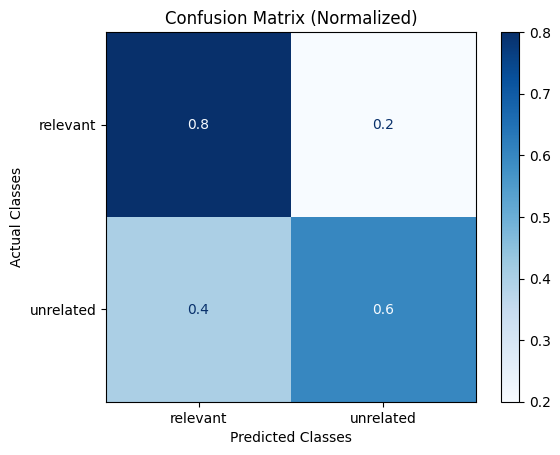

In [58]:
true_labels = df_sample["relevant"].map(RAG_RELEVANCY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications_4o, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications_4o, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for relevance, it can be useful to know why the LLM classified a document as relevant or irrelevant. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [65]:
small_df_sample = df_sample.copy().sample(n=5).reset_index(drop=True)
relevance_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    model=model_4o,
    rails=rails,
    provide_explanation=True,
    verbose=True,
    concurrency=20,
)

Using prompt:

[PromptPartTemplate(content_type=<PromptPartContentType.TEXT: 'text'>, template='\nYou are comparing a reference text to a question and trying to determine if the reference text\ncontains information relevant to answering the question. Here is the data:\n    [BEGIN DATA]\n    ************\n    [Question]: {input}\n    ************\n    [Reference text]: {reference}\n    ************\n    [END DATA]\nCompare the Question above to the Reference text. You must determine whether the Reference text\ncontains information that can help answer the Question. First, write out in a step by step manner\nan EXPLANATION to show how to arrive at the correct answer. Avoid simply stating the correct answer\nat the outset. Your response LABEL must be single word, either "relevant" or "unrelated", and\nshould not contain any text or characters aside from that word. "unrelated" means that the\nreference text does not help answer to the Question. "relevant" means the reference text directly\

<ipython-input-65-3e82647a33ce>:2: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  relevance_classifications_df = llm_classify(


llm_classify |          | 0/5 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'unrelated' to rail: unrelated
- Snapped 'unrelated' to rail: unrelated
- Snapped 'unrelated' to rail: unrelated
- Snapped 'relevant' to rail: relevant
- Snapped 'unrelated' to rail: unrelated


In [66]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, relevance_classifications_df, left_index=True, right_index=True
)
merged_df[["input", "reference", "label", "explanation"]].head()

,input,reference,label,explanation
0,where were pt boat hulls made in ww2?,"PT-105 underway. PT boats were a variety of torpedo-armed fast attack craft used by the United States Navy in World War II to attack larger surface ships. ""PT"" is the US hull classification symbol for ""Patrol Torpedo"". The PT boat squadrons were nicknamed ""the mosquito fleet"". The Japanese called them ""Devil Boats"". The original pre– World War I torpedo boats were designed with ""displacement"" hulls . They displaced up to 300 tons and the top speed was . The PT boats used in World War II were built using the planing -type hull form developed for racing boats . They were much smaller (30–75 tons) and faster (35–40 knots). Both types were designed to strike at larger warships with torpedoes , using relatively high speed to get close, and small size to avoid being spotted and hit by gunfire. They were much less expensive than large warships. PT boats were much faster, smaller, and cheaper than conventional (displacement hull) vessels. During World War II, American PT boats engaged enemy destroyers and numerous other surface craft, ranging from small boats to large supply ships. PT boats also operated as gunboats against enemy small craft, such as armored barges used by the Japanese forces for inter-island transport.",unrelated,"The question asks about the location where PT boat hulls were made during World War II. The reference text provides information about PT boats, including their design, purpose, and operational use during the war. However, it does not mention any specific locations or facilities where the hulls of PT boats were manufactured. The text focuses on the characteristics and roles of PT boats rather than their production sites. Therefore, the reference text does not contain information relevant to answering the question about the manufacturing locations of PT boat hulls."
1,when was the constitution written,"A constitution is a set of fundamental principles or established precedents according to which a state or other organization is governed. These rules together make up, i.e. constitute, what the entity is. When these principles are written down into a single document or set of legal documents, those documents may be said to embody a written constitution; if they are written down in a single comprehensive document, it is said to embody a codified constitution. Constitutions concern different levels of organizations, from sovereign states to companies and unincorporated associations. A treaty which establishes an international organization is also its constitution, in that it would define how that organization is constituted. Within states , whether sovereign or federated , a constitution defines the principles upon which the state is based, the procedure in which laws are made and by whom. Some constitutions, especially codified constitutions, also act as limiters of state power, by establishing lines which a state's rulers cannot cross, such as fundamental rights . George Washington at Constitutional Convention of 1787, signing of U.S. Constitution. The Constitution of India is the longest written constitution of any sovereign country in the world, containing 448 articles, 12 schedules and 100 amendments, with 117,369 words in its English language version, while the United States Constitution is the shortest written constitution, at 7 articles and 27 amendments.",unrelated,"The question asks about the date when the constitution was written. The reference text provides a general description of what a constitution is, its purpose, and some examples of constitutions, such as the U.S. Constitution and the Constitution of India. However, it does not provide any specific information about the date when any constitution, including the U.S. Constitution, was written. Therefore, the reference text does not contain information that directly answers the question about when the constitution was written."
2,what is the name of the founder o